![Image](../../resources/cropped-SummerWorkshop_Header.png)

<h1 align="center">Population Coding</h1> 
<h2 align="center"> Day 2, Afternoon Session</h2> 



<br>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
In the first workshop of today, we examined how sensory variables can be encoded in individual neurons' activity. We now turn our attention to the coordinated activity of groups of neurons: population codes!
    
### How do populations of neurons encode information about sensory stimuli? 
### How are these population codes modulated by context or behavioral state? 
### What other types of thing are encoded in population activity?
    
### We'll address these questions using the Visual Behavior Neuropixels data.

<br>
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
### Extracellular Electrophysiology Data

The data from in vivo extracellular electrophysiology experiments are organized into *sessions*, where each session is a distinct continuous recording period. During a session we collect:

- spike times and characteristics (such as mean waveforms) from up to 6 neuropixels probes
- local field potentials
- behavioral data, such as running speed and eye position and lick times
- visual stimuli which were presented during the session
- cell-type specific optogenetic stimuli that were applied during the session

The AllenSDK contains code for accessing across-session (project-level) metadata as well as code for accessing detailed within-session data. The standard workflow is to use project-level tools, such as `EcephysProjectCache` to identify and access sessions of interest, then delve into those sessions' data using `EcephysSession`.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [3]:
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)

Grab data from a session

In [4]:
session = cache.get_ecephys_session(
           ecephys_session_id=1065437523)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


The stimulus presentations table is a record of every stimulus we presented to the mouse over the course of this experiment. Let's take a look at this table.

In [5]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.head(-5)

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,position_y,stimulus_index,active,stimulus_name,rewarded,is_sham_change,spatial_frequency,position_x,contrast,orientation
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,5,im047_r,0.250210,8776.735046,8776.985256,522677,522692,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
13382,5,im047_r,0.250207,8777.485673,8777.735881,522722,522737,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
13383,5,im047_r,0.250208,8778.236296,8778.486503,522767,522782,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN


It contains a great deal of information about the stimulus trials! Let's look at all the columns:

In [6]:
stimulus_presentations.columns

Index(['stimulus_block', 'image_name', 'duration', 'start_time', 'end_time',
       'start_frame', 'end_frame', 'is_change', 'is_image_novel', 'omitted',
       'flashes_since_change', 'trials_id', 'color', 'temporal_frequency',
       'position_y', 'stimulus_index', 'active', 'stimulus_name', 'rewarded',
       'is_sham_change', 'spatial_frequency', 'position_x', 'contrast',
       'orientation'],
      dtype='object')

The experiment is divided into stimulus blocks. During each block a different set of stimuli are presented. A stimulus block can be active or passive. In active blocks, the mouse performs the change detection task introduced earlier. In passive blocks, there is no task.

The different stimuli are indexed by the 'stimulus_block' column. Let's group stimulus presentations dataframe by stimulus block and see what stimulus was shown for each block.

In [7]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations.groupby('stimulus_block')[['stimulus_block', 
                                                'stimulus_name', 
                                                'active', 
                                                'duration', 
                                                'start_time']].head()

,stimulus_block,stimulus_name,active,duration,start_time
stimulus_presentations_id,,,,,
0,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250188,28.131464
1,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250188,28.882028
2,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250232,29.632680
3,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250186,30.383329
4,0,Natural_Images_Lum_Matched_set_ophys_G_2019,True,0.250229,31.133886
4797,1,spontaneous,False,10.008420,3648.207579
4798,2,gabor_20_deg_250ms,False,0.250208,3658.215999
4799,2,gabor_20_deg_250ms,False,0.250208,3658.466207
4800,2,gabor_20_deg_250ms,False,0.250208,3658.716415


<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
What are the types of stimulus block that were presented?

In [8]:
stimulus_presentations['stimulus_name'].unique()

array(['Natural_Images_Lum_Matched_set_ophys_G_2019', 'spontaneous',
       'gabor_20_deg_250ms', 'flash_250ms'], dtype=object)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
What stimuli were shown in the 'Natural_Images_Lum_Matched_set_ophys_G_2019' block?

In [9]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == 'Natural_Images_Lum_Matched_set_ophys_G_2019']
stimulus_presentations.head(-5)

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,position_y,stimulus_index,active,stimulus_name,rewarded,is_sham_change,spatial_frequency,position_x,contrast,orientation
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,5,im047_r,0.250210,8776.735046,8776.985256,522677,522692,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
13382,5,im047_r,0.250207,8777.485673,8777.735881,522722,522737,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
13383,5,im047_r,0.250208,8778.236296,8778.486503,522767,522782,False,False,False,...,NaN,-99,False,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN


In [10]:
np.sort(stimulus_presentations['image_name'].unique())

array(['im012_r', 'im036_r', 'im044_r', 'im047_r', 'im078_r', 'im083_r',
       'im111_r', 'im115_r', 'omitted'], dtype=object)

Now let's get unit and channel data, sort the units by depth and filter for "good" units.

In [11]:
### get unit and channel data, sort the units by depth and filter for "good" units
units = session.get_units() # contains information about spike waveforms, isolation quality
channels = session.get_channels() # contains information about anatomical location

unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True) # associate anatomical information with each unit

#first let's sort our units by depth and filter
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))

good_units = unit_channels.loc[good_unit_filter]

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    Which brain structures were recorded from in this session? How many units are present in each structure? (Hint: try the "value_counts" function.)

In [12]:
unit_channels.value_counts('structure_acronym')

structure_acronym
SGN      260
CA1      228
DG       167
VISpm    165
APN      151
TH       146
VISam    144
VISp     131
VISl     127
VISal    125
MRN      106
VISrl     99
ProS      98
PP        94
PIL       74
PoT       70
CA3       67
SUB       52
LP        24
MGm       21
NOT       18
RN        17
MB        15
POST       2
LT         2
MGv        1
dtype: int64

### For now, let's look at the population activity in primary visual cortex

In [13]:
area_of_interest = 'VISp'
area_units = good_units[good_units['structure_acronym'] == area_of_interest]
num_units = len(area_units)

### Let's start by looking at the neural activity! Does it reflect the image presentation?

### The session.spike_times object contains all spike times, in seconds, indexed by the unit ID. Let's take a look at this object.

In [14]:
spike_times = session.spike_times
spike_times

{1068230174: array([9.44254618e+00, 2.33621481e+01, 2.34528150e+01, ...,
        9.50809482e+03, 9.51961755e+03, 9.52079809e+03]),
 1068230173: array([6.85353963e+00, 1.12225507e+01, 1.51770274e+01, ...,
        9.53846293e+03, 9.53847370e+03, 9.53979757e+03]),
 1068229957: array([4138.03009707, 4542.21778688, 4542.4386541 , ..., 9539.18743594,
        9539.33773632, 9539.83660425]),
 1068229949: array([4.66810076e+00, 4.71560088e+00, 4.72050090e+00, ...,
        9.53462899e+03, 9.53743216e+03, 9.53826630e+03]),
 1068229887: array([4.69210083e+00, 5.04563505e+00, 5.26246894e+00, ...,
        9.53967004e+03, 9.53979680e+03, 9.53983434e+03]),
 1068229886: array([4.70133418e+00, 5.09830185e+00, 5.35013582e+00, ...,
        9.53971987e+03, 9.53974080e+03, 9.53978037e+03]),
 1068229911: array([4.97070153e+00, 5.39926928e+00, 5.45693609e+00, ...,
        9.53975597e+03, 9.53984134e+03, 9.53989457e+03]),
 1068230009: array([5.59440311e+00, 7.24834063e+00, 1.64365972e+01, ...,
        9.539629

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

Get the array of spike times for unit 1068230173. How many times does this unit spike in the first minute of the experiment?

In [15]:
unit_spike_times = spike_times[1068230173]
unit_spike_times

array([6.85353963e+00, 1.12225507e+01, 1.51770274e+01, ...,
       9.53846293e+03, 9.53847370e+03, 9.53979757e+03])

In [16]:
sum(unit_spike_times < 60)

33

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">

Plot a population spike raster spanning 1 second before to 1 second after a stimulus presentation. Fill in the code in the for 

(0.0, 72.0)

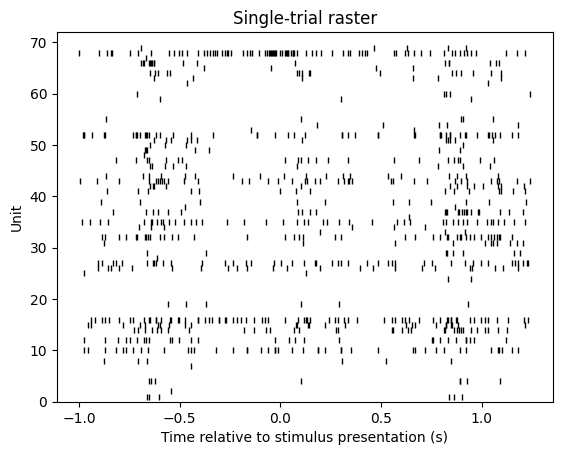

In [17]:
### plot a single-trial raster, population PSTH, and representation matrix
pre_time = 1
post_time = 1

fig, ax = plt.subplots(1, 1)

presentation_idx = 1
start_time = stimulus_presentations['start_time'][presentation_idx] # in seconds - start one second before this
end_time = stimulus_presentations['end_time'][presentation_idx] # in seconds - go to one second after this

unit_num = 0
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    
    unit_spike_times = unit_spike_times[(unit_spike_times >= start_time - pre_time) * (unit_spike_times < end_time + post_time)]
    unit_num_spikes = len(unit_spike_times)
    
    ax.plot(unit_spike_times - start_time, unit_num*np.ones(unit_num_spikes,), 'k|', markersize=5)
    unit_num += 1

ax.set_title('Single-trial raster')
ax.set_xlabel('Time relative to stimulus presentation (s)')
ax.set_ylabel('Unit')
ax.set_ylim((0, num_units+1))

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
Now let's compare to a change trial.

(0.0, 71.0)

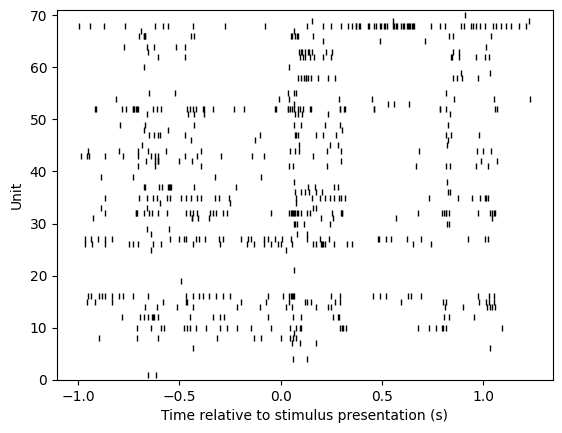

In [18]:

### plot a single-trial raster, population PSTH, and representation matrix
fig, ax = plt.subplots(1, 1)

change_idx = np.where(stimulus_presentations['is_change'].values)[0]
presentation_idx = change_idx[0]

start_time = stimulus_presentations['start_time'][presentation_idx]
end_time = stimulus_presentations['end_time'][presentation_idx]

unit_num = 0
for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]
    
    unit_spike_times = unit_spike_times[(unit_spike_times >= start_time - pre_time) * (unit_spike_times < end_time + post_time)]
    unit_num_spikes = len(unit_spike_times)
    
    ax.plot(unit_spike_times - start_time, unit_num*np.ones(unit_num_spikes,), 'k|', markersize=5)
    unit_num += 1

ax.set_xlabel('Time relative to stimulus presentation (s)')
ax.set_ylabel('Unit')
ax.set_ylim((0, num_units))

### Now let's take a look at the trial-averaged responses to see how a neuron encodes the stimulus in its time-dependent firing rate (its peri-stimulus time histogram, or PSTH).

In [19]:
#Convenience function to compute the PSTH
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/startTimes.size
    return counts/binSize, bins

Let's start by plotting the response of unit 0 to one of the images.

In [20]:
stimuli = stimulus_presentations['image_name'].unique()
stimulus = stimuli[0]

In [21]:
print(stimuli)

['im036_r' 'im078_r' 'omitted' 'im111_r' 'im047_r' 'im083_r' 'im012_r'
 'im115_r' 'im044_r']


In [22]:
presentations = stimulus_presentations[stimulus_presentations['image_name'] == stimulus]
num_presentations = len(presentations)

start_times = presentations['start_time'].values

In [23]:
unit_ids = area_units.index
iu = unit_ids[0]
unit_spike_times = spike_times[iu]

Text(0.5, 1.0, 'PSTH for im036_r')

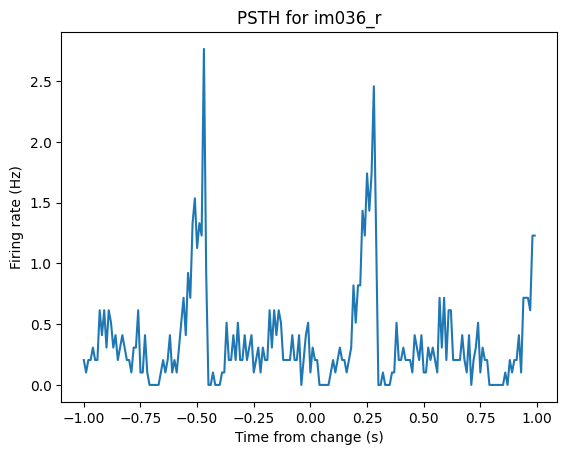

In [24]:
time_before_im = 1
duration = 2

unit_response, bins = makePSTH(unit_spike_times, 
                                  start_times - time_before_im, 
                                  duration, binSize=0.01)

fig, ax = plt.subplots(1, 1)
ax.plot(bins[:-1] - time_before_im, unit_response)
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
Plot the PSTHs for every unit to that image.

Text(0.5, 1.0, 'PSTH for im036_r')

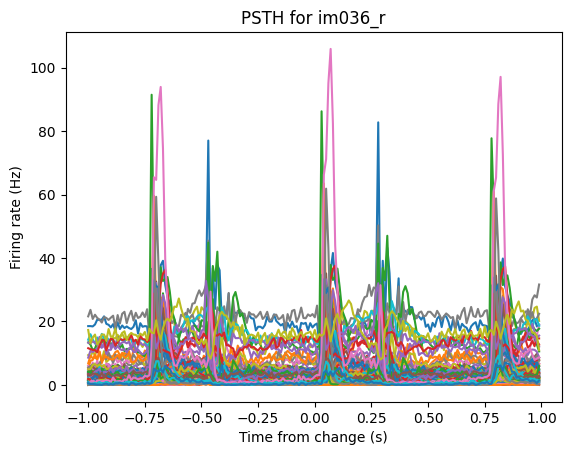

In [25]:
### Plot a set of PSTHs

psths = []
fig, ax = plt.subplots(1, 1)

for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]  
    unit_response, bins = makePSTH(unit_spike_times, 
                                      start_times - time_before_im, 
                                      duration, binSize=0.01)
    
    psths.append(unit_response)
    ax.plot(bins[:-1]-time_before_im, unit_response)
    
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

We can see the trial structure of the task reflected in the PSTH. Some units have very strong transient responss to the image presentation. 

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
Plot the PSTHs for every unit to another image. Do the same neurons have the strongest responses?

Text(0.5, 1.0, 'PSTH for im078_r')

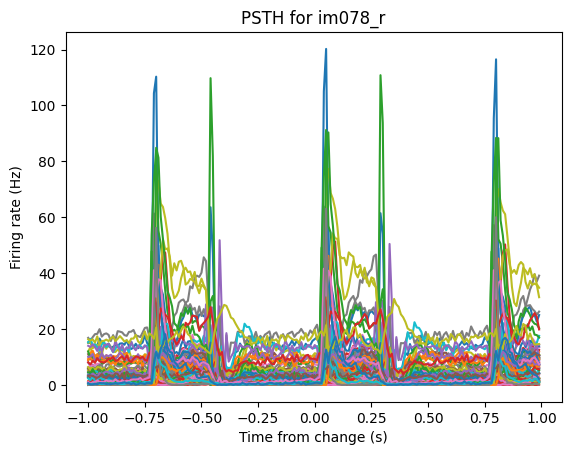

In [26]:
stimulus = stimuli[1]

presentations = stimulus_presentations[stimulus_presentations['image_name'] == stimulus]
num_presentations = len(presentations)

start_times = presentations['start_time'].values

fig, ax = plt.subplots(1, 1)

for iu, unit in area_units.iterrows():
    unit_spike_times = spike_times[iu]  
    unit_response, bins = makePSTH(unit_spike_times, 
                                      start_times - time_before_im, 
                                      duration, binSize=0.01)
    
    psths.append(unit_response)
    ax.plot(bins[:-1]-time_before_im, unit_response)
    
ax.set_xlabel('Time from change (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('PSTH for {}'.format(stimulus))

## Training a classifier on population spiking data

In order to determine how well we can decode the stimulus direction from population activity, we will train a **classifier** on our matrix of firing rates. Whereas regression models try to predict continuous values from the input features, classification models try to predict *labels* (also known as classes) from the input features.

### Support Vector Machines

Let's start with a linear Support Vector Machine (SVM) classifier, which will try to draw linear boundaries between orientation conditions (the labels) in our 94-dimensional firing rate space.

This cartoon shows how we would expect an SVM to behave on a much simpler dataset, which has two dimensions and three conditions:

![SVM illustration](../../resources/svm-classifier.png)

SVM computes decision boundaries in feature space that can be used to classify different conditions. If a new data point appears, the SVM classifier will label it based on where it falls with respect to these boundaries.

To train an SVM, we need to import the following methods from `scikit-learn`:

In [27]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

### First, we need to create a response matrix and vector of stimulus labels.

In [28]:
stimulus_presentations = session.stimulus_presentations
stimulus_presentations = stimulus_presentations[stimulus_presentations.stimulus_name == 'Natural_Images_Lum_Matched_set_ophys_G_2019']
stimulus_presentations = stimulus_presentations[stimulus_presentations.active]

num_presentations = len(stimulus_presentations)
stimulus_presentations.head()

,stimulus_block,image_name,duration,start_time,end_time,start_frame,end_frame,is_change,is_image_novel,omitted,...,position_y,stimulus_index,active,stimulus_name,rewarded,is_sham_change,spatial_frequency,position_x,contrast,orientation
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,0,im036_r,0.250188,28.131464,28.381652,60,75,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
1,0,im036_r,0.250188,28.882028,29.132216,105,120,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
2,0,im036_r,0.250232,29.632680,29.882912,150,165,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
3,0,im036_r,0.250186,30.383329,30.633515,195,210,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN
4,0,im036_r,0.250229,31.133886,31.384115,240,255,False,False,False,...,NaN,-99,True,Natural_Images_Lum_Matched_set_ophys_G_2019,False,False,NaN,NaN,NaN,NaN


In [29]:
def make_response_array(spike_times, stimulus_presentations, units, window=.05):

    '''
    Create an array of spike counts x stimulus presentations, and a corresponding list of stimulus label
    spike_times: spike times 
    stimulus_presentation: stimulus presentation table
    units: units table containing only the units to get the responses of
    '''

    # sort spike times chronologically; necessary for the binary search later
    sorted_spikes = dict()
    for iu in units.index:
        # mergesort/timsort since most spike_times are already sorted
        sorted_spikes[iu] = np.sort(spike_times[iu], kind='mergesort')

    # create our own copy of stimulus presentations and sort by presentation start time chronologically
    # sortation of stimulus_presentations isn't necessary, but it speeds up the vectorized `searchsorted(...)`
    stimulus_presentations = stimulus_presentations.sort_values(by='start_time', kind='mergesort', inplace=False)

    # Calculate the duration of stimulus presentations, and drop NaN durations
    stimulus_presentations['duration'] = stimulus_presentations['end_time'] - stimulus_presentations['start_time']
    stimulus_presentations.dropna(subset='duration', inplace=True)
    
    # Warn if window size is too big
    if np.any(window > stimulus_presentations['duration']):
        print('Warning: window size longer than stimulus presentation')

    responses_by_unit = list()
    for iu in units.index:
        unit_spike_times = sorted_spikes[iu]

        # Determine the first and last spike time for each stimulus presentation
        start_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time'])
        end_is = np.searchsorted(unit_spike_times, stimulus_presentations['start_time']+window)

        # presentation_spike_times = unit_spike_times[start_i:end_i]

        # Calculate the response rate for each stimulus presentation
        responses_by_unit.append((end_is - start_is) / window)

    # responses_by_unit has each row a unit, and each column a stimulus, flip so that rows are stimuli
    responses = np.transpose(responses_by_unit)

    # Extract the labels that match the responses from our sorted stimulus presentations table
    labels = np.array(stimulus_presentations['image_name'])
    
    return responses, labels

In [30]:
responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window=.02)

We will first select a random subset of trials for training the classifier:

In [31]:
total_presentations = responses.shape[0]
num_train = int(total_presentations * 0.5) # Use 50% of trials for training
random_trial_order = np.random.permutation(responses.shape[0])
train_indices = random_trial_order[:num_train]

training_data = responses[train_indices]
training_labels = labels[train_indices]

Next, we'll create the model and fit it to our training data:

In [32]:
clf = svm.SVC()
clf.fit(responses[train_indices], labels[train_indices])

SVC()

Now that our model has been trained, we can ask it to classify unlabeled data (i.e., the sets of population firing rates that were not included in our original training set):

In [33]:
test_indices = random_trial_order[num_train:]
test_data = responses[test_indices]
predicted_labels = clf.predict(responses[test_indices])

We can compare the predicted labels to the actual labels in order to assess the classifier's performance. We'll assess accuracy as the fraction of correctly predicted test images. As a baseline, we'll also compute the accuracy of a uniform random prediction.

In [34]:
def convert_labels_to_int(labels, conditions):

    conversion_dict = {}
    for i, label in enumerate(conditions):
        conversion_dict[label] = i

    labels_as_int = [conversion_dict[l] for l in labels]

    return labels_as_int    
    

In [35]:
conditions = np.unique(labels)

actual_labels = labels[test_indices]
accuracy = np.mean(actual_labels == predicted_labels)

print('Accurary: {}'.format(accuracy))
print('Chance level: {}'.format(1/len(conditions)))

Accurary: 0.18757815756565235
Chance level: 0.1111111111111111


We see that we perform better than chance, but not very well! We can get a better sense of classification performance by using the `scikit-learn.model_selection.KFold` iterator to automatically split up the data into "train" and "test" sets for 5 iterations. Note that the model is fit independently on each iteration.

In [36]:
accuracies = []
confusions = []

conditions = np.unique(labels)
num_splits = 5

for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
    
    clf = svm.SVC()
#     clf = RandomForestClassifier(min_samples_leaf=20)
#     clf = LinearDiscriminantAnalysis()

    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

0.19479166666666667
0.19270833333333334
0.20229405630865485
0.18561001042752867
0.17935349322210636

mean accuracy: 0.190951511991658
chance: 0.1111111111111111


The 5-fold cross-validation roughly agrees with our previous result. Are there particular stimuli that drive the errors? Do assess this we'll look at the confusion matrix, which tells us how frequently stimulus 1 is predicted when any stimulus is shown (and so on).

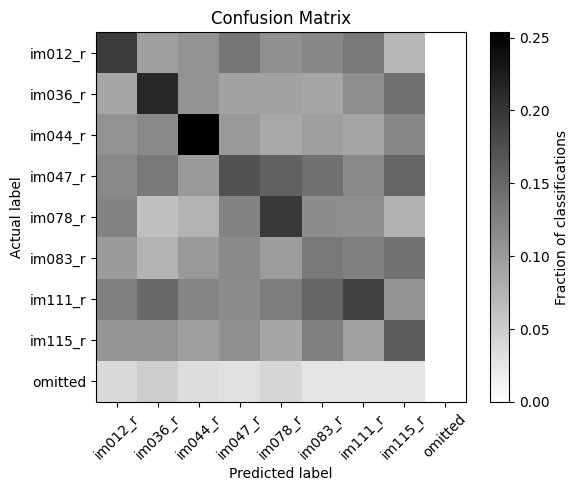

In [37]:
def plot_confusion_matrix(confusions, conditions):
    
    mean_confusion = np.mean(confusions, axis=0)

    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(mean_confusion, cmap='gray_r')
    plt.colorbar(im, ax=ax, label='Fraction of classifications')
    
    ax.set_xticks(range(len(conditions)), conditions, rotation=45)
    ax.set_yticks(range(len(conditions)), conditions)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("Actual label")
    ax.set_title('Confusion Matrix')
    
plot_confusion_matrix(confusions, conditions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
What structure do you see in the confusion matrix? Do the most accurately decoded images look similar? (Use the session.stimulus_templates object to get the images.)

In [38]:
session.stimulus_templates.head()

,unwarped,warped
image_name,,
im036_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[70, 71, 67, 63, 64, 69, 73, 73, 71, 70, 73, ..."
im012_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[25, 27, 21, 14, 15, 23, 29, 28, 22, 18, 20, ..."
im044_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[20, 23, 16, 9, 9, 18, 24, 23, 16, 12, 14, 20..."
im047_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[63, 65, 62, 58, 58, 63, 67, 67, 65, 64, 65, ..."
im083_r,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[6, 9, 2, 0, 0, 0, 7, 5, 0, 0, 0, 2, 7, 6, 2,..."


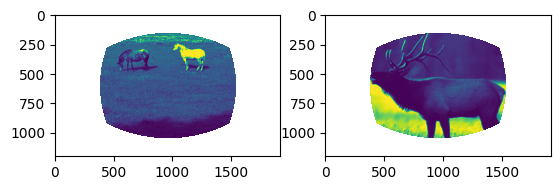

In [39]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(session.stimulus_templates['unwarped']['im036_r'])
ax[1].imshow(session.stimulus_templates['unwarped']['im044_r'])

What do you think would happen if some of the images were new to the mouse?

## Exploring the time course of visual information 


Next we'll examine the time course of information in our population! Or more specifically: how the length of the spike count window affects the decoding accuracy. Can we decode the stimulus perfectly if we integrate spikes for long enough?

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
First, let's try decoding with a longer response window of .1 seconds.

In [40]:
responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window=.1)

0.9833333333333333
0.990625
0.9916579770594369
0.9885297184567258
0.9947862356621481

mean accuracy: 0.9897864529023288
chance: 0.1111111111111111


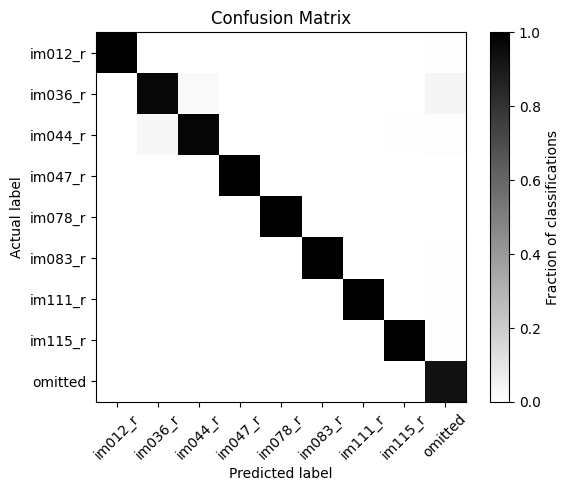

In [41]:
accuracies = []
confusions = []

conditions = np.unique(labels)
num_splits = 5

for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
    
#     clf = svm.SVC(gamma="scale", kernel="rbf")
#     clf = RandomForestClassifier(min_samples_leaf=20)
    clf = LinearDiscriminantAnalysis()

    clf.fit(responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
    print(accuracy)
    
    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

plot_confusion_matrix(confusions, conditions)

With a long response window we can decode the stimulus perfectly!

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
How long do we need to integrate spikes in order to decode perfectly?

In [42]:
window_lengths = np.arange(.01, .1, .02)

In [43]:
accuracies = np.zeros((len(window_lengths), num_splits))

for i, window in enumerate(window_lengths):
    print('{}/{}'.format(i, len(window_lengths)))
    responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window)
    
    k = 0
    for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
        clf = svm.SVC()
        clf.fit(responses[train_indices], labels[train_indices])

        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])

        accuracies[i, k] = np.mean(test_targets == test_predictions)        
              
        k += 1

0/5
1/5
2/5
3/5
4/5


Text(0, 0.5, 'Accuracy')

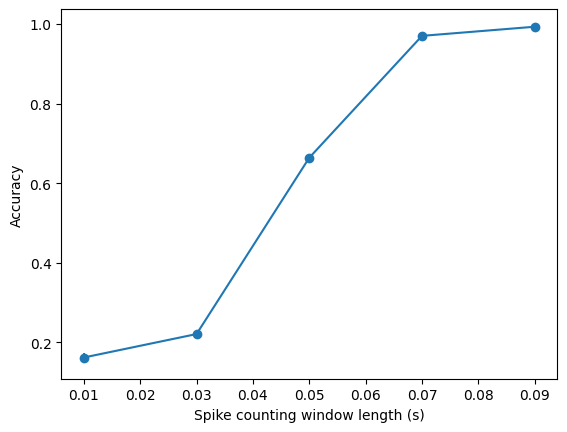

In [44]:
fig, ax = plt.subplots()
ax.errorbar(x=window_lengths, y=accuracies.mean(axis=(1)), yerr=accuracies.std(axis=(1)), fmt='o-')
ax.set_xlabel('Spike counting window length (s)')
ax.set_ylabel('Accuracy')

## Relationship between population size and decoding accuracy

Next we'll examine how the size of the simultaneously recorded population affects decoding accuracy. In any physiology experiment, we only have a very small window into the overall population response. For example, there are about 500,000 neurons in mouse V1, so in this case we are measuring around 0.02% of the firing rates in this region.

As the number of simultaneously recorded neurons increases, we expect that our ability to decode stimulus identity will improve. 

To start with, let's try decoding with a random sample of 10 neurons. Note: here we're using the responses from our longest window above. So, if we used the full population we would be able to decode perfectly.


mean accuracy: 0.6176740093847759
chance: 0.1111111111111111


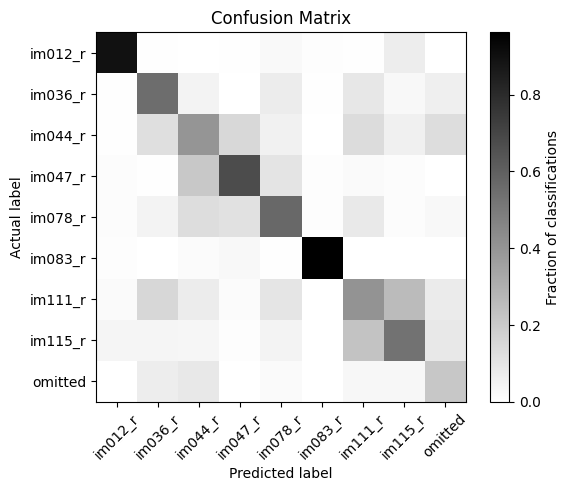

In [45]:
pop_size = 10

pop_idx = np.random.choice(range(num_units), size=pop_size)
responses_pop = responses[:, pop_idx]

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses_pop):
    clf = svm.SVC()
    clf.fit(responses_pop[train_indices], labels[train_indices])

    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses_pop[test_indices])

    accuracy = np.mean(test_targets == test_predictions)    

    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

plot_confusion_matrix(confusions, conditions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
Does the result depend on which 10 neurons we sampled? Let's try another random sample.


mean accuracy: 0.5495116440736879
chance: 0.1111111111111111


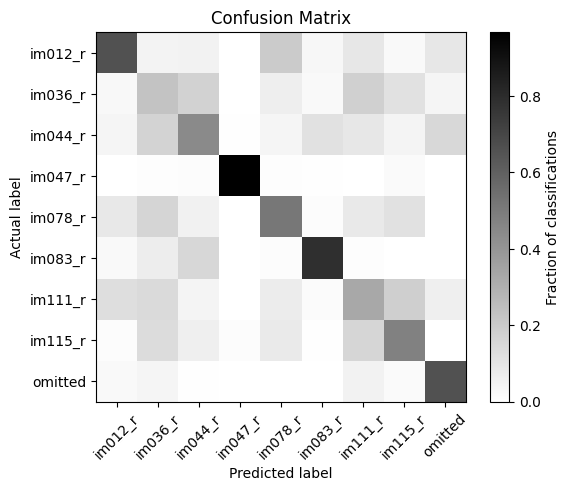

In [46]:
pop_idx = np.random.choice(range(num_units), size=pop_size)
responses_pop = responses[:, pop_idx]

accuracies = []
confusions = []

for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses_pop):
    clf = svm.SVC()
    clf.fit(responses_pop[train_indices], labels[train_indices])

    test_targets = labels[test_indices]
    test_predictions = clf.predict(responses_pop[test_indices])

    accuracy = np.mean(test_targets == test_predictions)    

    accuracies.append(accuracy)
    confusions.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy: {np.mean(accuracies)}")
print(f"chance: {1/conditions.size}")

plot_confusion_matrix(confusions, conditions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
### Now, let's try to get a sense for how this changes with the number of neurons we use to train the classifier. 
    
### How many neurons do you need to decode with roughly 50% accuracy? 80%? 90%? Finish the code below.

In [47]:
pop_sizes = np.arange(1, 50, 5).astype('int')
num_resamples = 10

accuracies = np.zeros((len(pop_sizes), num_resamples, num_splits))

for i, pop_size in enumerate(pop_sizes):
    print('population size: {}'.format(pop_size))

    for j in range(num_resamples):
        pop_idx = np.random.choice(range(num_units), size=pop_size)
        responses_pop = responses[:, pop_idx]

        k = 0
        for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses_pop):
            clf = svm.SVC()
            clf.fit(responses_pop[train_indices], labels[train_indices])

            test_targets = labels[test_indices]
            test_predictions = clf.predict(responses_pop[test_indices])

            accuracy = np.mean(test_targets == test_predictions)    

            accuracies[i, j, k] = accuracy
            k += 1

population size: 1
population size: 6
population size: 11
population size: 16
population size: 21
population size: 26
population size: 31
population size: 36
population size: 41
population size: 46


Text(0, 0.5, 'Accuracy')

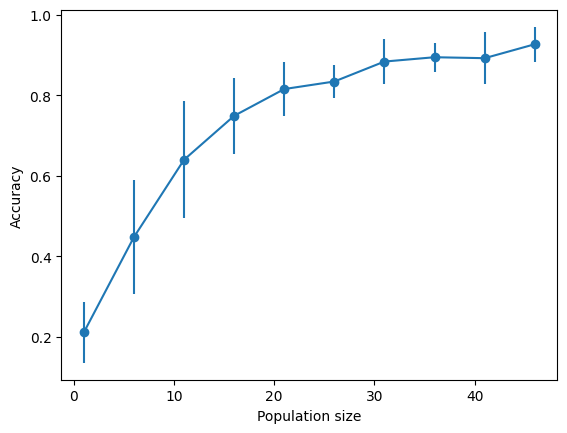

In [48]:
fig, ax = plt.subplots()
ax.errorbar(x=pop_sizes, y=accuracies.mean(axis=(1, 2)), yerr=accuracies.std(axis=(1, 2)), fmt='o-')

ax.set_xlabel('Population size')
ax.set_ylabel('Accuracy')

Roughly how many neurons do you need to decode with 50% accuracy? 80%? 90%?

## Exploring correlations between neurons

Finally, we turn to examine the structure of the population activity.
Does the structure of the population activity matter for this decoding, or is single-neuron tuning the whole name of the game? For example, if neurons 1 and 2 are co-active on trial 1 (both above their individual mean activity), does that carry any extra information? To explore this, we'll look at correlations between their responses.

<!-- Based on the plot above, it's clear that neurons are correlated with one another. For example, look at units 35-40 and notice how they tend to have high firing rates or low firing rates on similar trials. -->

We'll look at this correlation in much more detail below, but we should first note some assumptions. Primarily, we are studying *spike counts*, or rates within time windows defined by the stimulus. This assumes that all spikes within the windows are equivalent, no matter their relative timing. It also assumes a specific set of time windows (set by the stimulus). In some cases, these assumptions may not be desirable (e.g., in studies of time-lagged spike-spike correlation, frequently used in studies of functional connectivity.)

With that tangent aside, let's return to our observation that the neurons' activities (defined here by spike rates) are correlated.

<!-- The activities of correlated neural populations have a *lower dimensionality* than the number of neurons. For example, for two perfectly correlated neurons, a single number suffices to describe both of their firing rates. This same idea applies to larger populations, and to less-than-perfect correlations. -->

<!-- To explore this property, we will apply the most common dimensionality reduction technique in existence to these data: Principal Component Analysis (PCA). This is a linear dimensionality reduction method (more on this later), and it works by considering the space of all possible neuron responses, wherein each axis of the space is a single neuron's firing rate. PCA finds the directions in this space along which the activities are the most spread out (highest variance) or the least spread out. -->

## Computing correlation matrices

For the following analysis, we will look at Pearson correlations: the Pearson correlation for a pair of neurons is the covariance divided by the product of the neurons' standard deviations. This normalizes the measure so that its maximum is 1 and minimum is -1, which makes it easier to interpret than covariances.

So far, we have not considered how much of the covariance or correlation is stimulus-driven (e.g., reflecting neurons with similar tuning responding to the same stimulus at the same time) vs arising from other sources. 

The correlations due to the stimulus properties are called *signal correlations*, whereas correlations due to other sources (including random variability within the eyes and the brain) are called *noise correlations*. The correlations we considered above encapsulate both of these factors, and are called *total* correlations.

To separate these out, we'll now compute and compare all 3 (Pearson) correlation matrices: the total correlations, signal correlations, and noise correlations.

First, the total correlations (using `np.corrcoef`):

In [49]:
# here, let's use a long response window
responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window=.2)

Text(0, 0.5, 'Unit #')

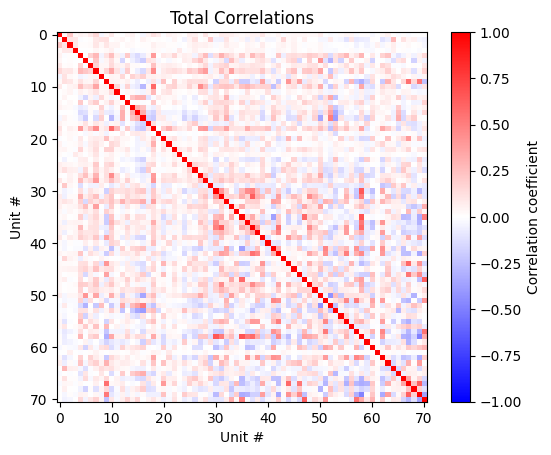

In [50]:
total_correlations = np.corrcoef(responses.T)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(total_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Total Correlations')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Next, we'll compute the signal correlations. These are the correlations in the neurons' average response to each stimulus, computed across stimuli. As the name implies, they tell us how much two neurons' mean (trial averaged) activities co-vary as the stimulus changes.

To compute these, we'll first calculate the average activities for each stimulus identify and neuron.

In [51]:
### Compute trial-averaged response to each stimulus (aka tuning curves) using our response array
stimuli = stimulus_presentations['image_name'].unique()
num_stim = len(stimuli)

tuning_curves = np.zeros((num_units, num_stim))

for j, stim in enumerate(stimuli):
    stim_idx = np.where(labels == stim)
    tuning_curves[:, j] = np.mean(responses[stim_idx], axis=0)

Text(0.5, 1.0, 'Tuning curves')

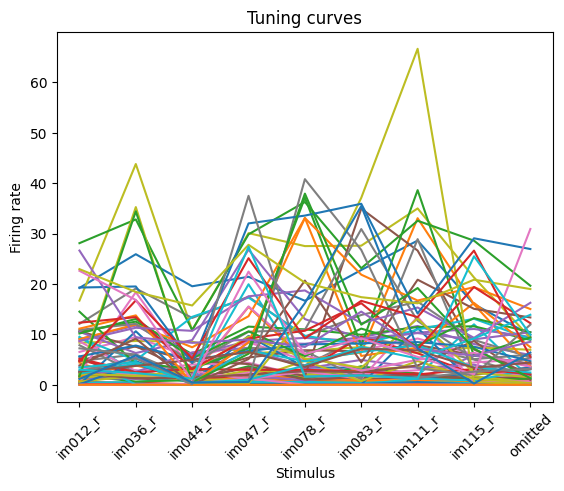

In [52]:
fig, ax = plt.subplots(1, 1)

ax.plot(tuning_curves.T);
ax.set_xticks(range(len(conditions)), conditions, rotation=45)
ax.set_xlabel('Stimulus')
ax.set_ylabel('Firing rate')
ax.set_title('Tuning curves')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
The signal correlation matrix is the pearson correlation of neuron's trial-averaged responses---the similarity of their tuning curves. Calculate and plot the signal correlation matrix.

Text(0, 0.5, 'Unit #')

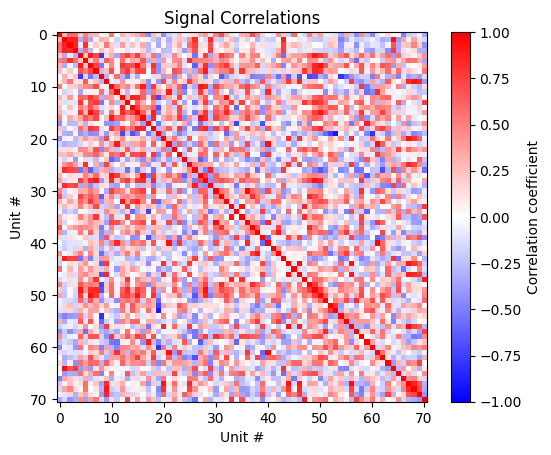

In [53]:
signal_correlations = np.corrcoef(tuning_curves)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(signal_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Signal Correlations')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Finally, let's compute the noise correlations. These are the correlations in the responses to each stimulus, reflecting the (correlated) trial-to-trial variability in the neural population. These correlations can come from synaptic connections (or indirect connections) between the neurons, so that when neuron A fires more on a given trial, neuron B also fires more (excitatory connection), or neuron B fires less (inhibitory connection). The noise correlations can also come from shared input. For example, if neuron C has an excitatory projection to both neurons A and B, then on trials where neuron C has increased firing rate, then both neurons A and B will also show increased firing.

These noise correlations are defined on a per-stimulus basis and can vary somewhat between stimuli. For sake of interest, we'll plot below the correlation matrices for two different stimuli, and we'll later make use of the average correlation matrix (averaged over all 8 orientations).

Since noise correlations are single-trial correlations, if a neuron does not respond to a particular stimulus condition it can generate NaNs when we divide by the standard deviation of the responses. To ignore these, we use numpy's masked array module, numpy.ma.

In [54]:
noise_correlations = np.zeros((len(conditions), num_units, num_units)) # initialize the noise correlation matrix for each stimulus condition

for i, condition in enumerate(stimuli):
    condition_idx = np.where(labels == condition)
    responses_condition = responses[condition_idx]    
    noise_correlations[i] = np.ma.corrcoef(responses_condition.T)

Text(0, 0.5, 'Unit #')

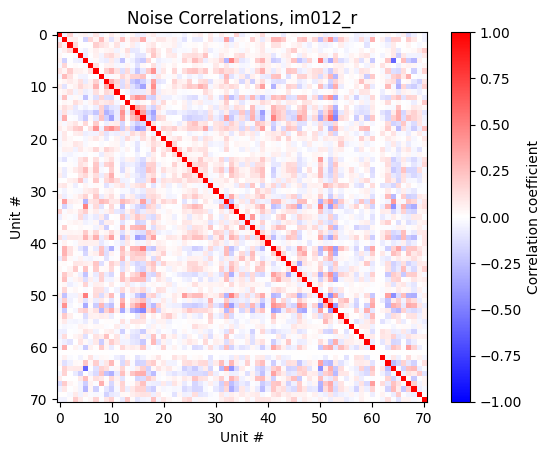

In [55]:
plot_condition_idx = 0

fig, ax = plt.subplots(1, 1)

im = ax.imshow(noise_correlations[plot_condition_idx], cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Noise Correlations, {}'.format(conditions[plot_condition_idx]))
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Text(0, 0.5, 'Unit #')

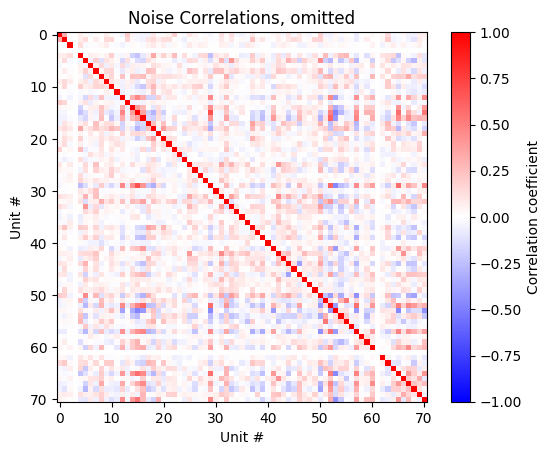

In [56]:
plot_condition_idx = -1

fig, ax = plt.subplots(1, 1)

im = ax.imshow(noise_correlations[plot_condition_idx], cmap='bwr', clim=(-1,1))
plt.colorbar(im, ax=ax, label='Correlation coefficient')
ax.set_title('Noise Correlations, {}'.format(conditions[plot_condition_idx]))
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

Note that noise correlations can vary between stimuli! What differences do you see between these two noise correlation matrices?

To get an overall view of the noise correlations, we average them across stimuli:

Mean noise correlation: 0.01818016484530918


Text(0, 0.5, 'Unit #')

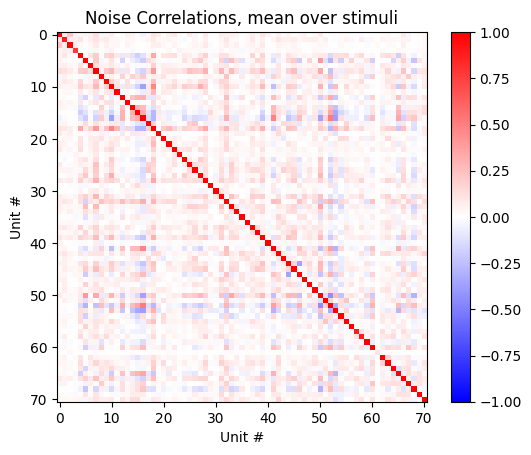

In [57]:
mean_noise_correlations = np.mean(noise_correlations,axis=0)

print('Mean noise correlation: {}'.format(np.mean(np.triu(mean_noise_correlations, 1))))

fig, ax = plt.subplots(1, 1)
im = ax.imshow(mean_noise_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im)
ax.set_title('Noise Correlations, mean over stimuli')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
A common interpretation of noise correlations is that they can arise from synapses between, or common input to, a pair of neurons. These can also affect (or, through Hebbian learning, reflect) stimulus tuning. So we might expect noise and signal correlations to be correlated.
    
The scipy.stats function pearsonr computes the pearson correlation and a a p-value from the hypothesis test where the null ypothesis is zero correlation. Are the noise and signal correlations significantly correlated?
    
Make sure to only compare the off-diagonal elements of the noise and signal correlation matrices, since the diagonal elements are all 1 by definition. 

Mean Noise Correlation:
0.0368797629719129
Mean Signal Correlation:
0.1203913366762584


Text(0, 0.5, 'Noise Correlation')

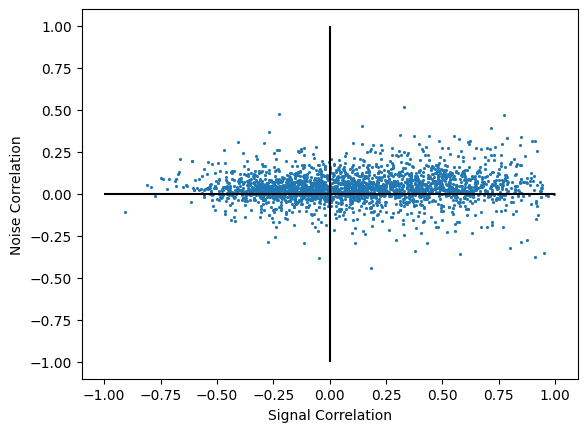

In [58]:
ncorr = np.matrix.flatten(mean_noise_correlations)
diagonal_indices = np.diag_indices(num_units, ndim=2) 
flat_diagonal_indices = np.ravel_multi_index(diagonal_indices, dims=(num_units, num_units))
ncorr = np.delete(ncorr, flat_diagonal_indices)

print('Mean Noise Correlation:')
print(np.mean(ncorr))

scorr = np.matrix.flatten(signal_correlations)
scorr = np.delete(scorr,flat_diagonal_indices)

print('Mean Signal Correlation:')
print(np.mean(scorr))

fig, ax = plt.subplots()
ax.scatter(scorr,ncorr,s=1)
ax.hlines(0,-1,1,colors='black')
ax.vlines(0,-1,1,colors='black')
ax.set_xlabel('Signal Correlation')
ax.set_ylabel('Noise Correlation')

At first these look ~unrelated to each other! If we look closer, we'll note that there is a small (but statistically quite significant) trend for neuron pairs with higher signal correlation to have higher noise correlation, and vice versa.

For this, we'll use the scipy pearsonr function instead of numpy corrcoef, because it returns a p-value from the hypothesis test where the null hypothesis is zero correlation.

In [59]:
from scipy.stats import pearsonr
pearsonr(ncorr,scorr)

PearsonRResult(statistic=0.06511563193507595, pvalue=4.342918239881614e-06)

Various computational models make predictions about the relation between noise and signal correlations. For example, the local competition algorithm for sparse coding, which was once a leading theory of V1 computation, predicts a negative relationship between noise and signal correlations.

## Population decoding with and without noise correlations

While the noise correlations are weak, it is worth asking whether or not -- from an information processing standpoint -- we can treat each neuron as independent. In other words, are the noise correlations weak enough that they can be ignored?

To test this, we'll return to our decoding analysis, and we will try decoding from synthetic data in which we artificially remove the noise correlations. We do this by trial-shuffling the neural data. This creates a fake dataset in which non-simultaneously-recorded neural activities are assembled to make the population response vectors, and it removes the noise correlations.

To do this, we go through the data, and for each stimulus, and for each neuron, we randomly (and independently) re-order the trials.

In [60]:
def trial_shuffle_responses(responses, conditions):
    
    shuffled_responses = responses.copy()

    for i, condition in enumerate(conditions):
        condition_idx = np.where(labels == condition)

        for j in range(num_units):
            responses_unit_condition = responses[condition_idx, j].reshape(-1).copy()
            np.random.shuffle(responses_unit_condition) # shuffle in place
            shuffled_responses[condition_idx, j] = responses_unit_condition
            
    return shuffled_responses

shuffled_responses = trial_shuffle_responses(responses, conditions)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
First, let's double-check that our shuffling worked correctly. Compute the noise correlations in the shuffled data, and plot the histogram of the off-diagonal elements of the true noise correlations and of the shuffled-response noise correlations. 
    
We'd expect to see that the trial-shuffled noise correlations are distributed closely around 0, with non-zero values only due to the finite sampling.

In [61]:
shuffled_noise_correlations = np.zeros((len(conditions), num_units, num_units)) # initialize the noise correlation matrix for each stimulus condition

for i, condition in enumerate(conditions):
    condition_idx = np.where(labels == condition)
    responses_condition = shuffled_responses[condition_idx]
    responses_condition = np.ma.masked_invalid(responses_condition)
    
    shuffled_noise_correlations[i] = np.ma.corrcoef(responses_condition.T)

Mean noise correlation after trial shuffling: 7.928792054403816e-05


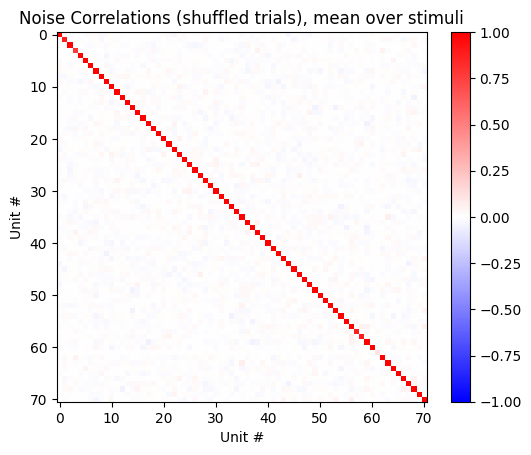

In [62]:
mean_shuffled_noise_correlations = np.mean(shuffled_noise_correlations,axis=0)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(mean_shuffled_noise_correlations, cmap='bwr', clim=(-1,1))
plt.colorbar(im)
ax.set_title('Noise Correlations (shuffled trials), mean over stimuli')
ax.set_xlabel('Unit #')
ax.set_ylabel('Unit #')

print('Mean noise correlation after trial shuffling: {}'.format(np.mean(np.triu(mean_shuffled_noise_correlations, 1))))

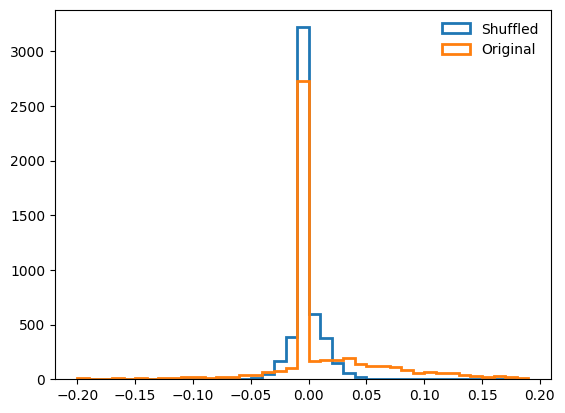

In [63]:
bins=np.arange(-.2, .2, .01)

fig, ax = plt.subplots()
ax.hist(np.triu(mean_shuffled_noise_correlations, 1).reshape(-1,), bins=bins, histtype='step', linewidth=2, label='Shuffled')
ax.hist(np.triu(mean_noise_correlations, 1).reshape(-1,), bins=bins, histtype='step', linewidth=2, label='Original')
ax.legend(loc=0, frameon=False)

<div style="border-left: 3px solid #000; padding: 10px; padding-left: 10px; padding-bottom: 10px; background: #c8e0bf; ">
    
Now let's decode from the trial-shuffled responses!

In [64]:
accuracies_shuffled = []
confusions_shuffled = []

for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):

    clf = svm.SVC()

    clf.fit(shuffled_responses[train_indices], labels[train_indices])
    
    test_targets = labels[test_indices]
    test_predictions = clf.predict(shuffled_responses[test_indices])
    
    accuracy = np.mean(test_targets == test_predictions)    
    print(accuracy)
    
    accuracies_shuffled.append(accuracy)
    confusions_shuffled.append(confusion_matrix(y_true=test_targets, y_pred=test_predictions, labels=conditions, normalize='pred'))
    
print(f"\nmean accuracy, shuffled trials: {np.mean(accuracies_shuffled)}")
print(f"chance: {1/conditions.size}")

1.0
0.9989583333333333
0.9979144942648592
0.9979144942648592
0.9979144942648592

mean accuracy, shuffled trials: 0.998540363225582
chance: 0.1111111111111111


# With these analyses in hand, we leave you with some questions:

### If you integrate spikes in a fixed window length, how does the decoding accuracy depend on the time since the image presentation? 

### Do noise correlations impact the decoding on specific timescales or for specific population sizes?

In [65]:
### timescales (fixed population size)

window_lengths = np.arange(.01, .1, .02)

accuracies = np.zeros((len(window_lengths), num_splits))
shuffled_accuracies = np.zeros((len(window_lengths), num_splits))

for i, window in enumerate(window_lengths):
    print('{}/{}'.format(i, len(window_lengths)))
    responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window)
    shuffled_responses = trial_shuffle_responses(responses, conditions)
    
    k = 0
    for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses):
        clf = svm.SVC()
        clf.fit(responses[train_indices], labels[train_indices])

        test_targets = labels[test_indices]
        test_predictions = clf.predict(responses[test_indices])

        accuracies[i, k] = np.mean(test_targets == test_predictions)        
        
        clf.fit(shuffled_responses[train_indices], labels[train_indices])

        test_targets = labels[test_indices]
        test_predictions = clf.predict(shuffled_responses[test_indices])

        shuffled_accuracies[i, k] = np.mean(test_targets == test_predictions) 
              
        k += 1

0/5
1/5
2/5
3/5
4/5


Text(0, 0.5, 'Accuracy')

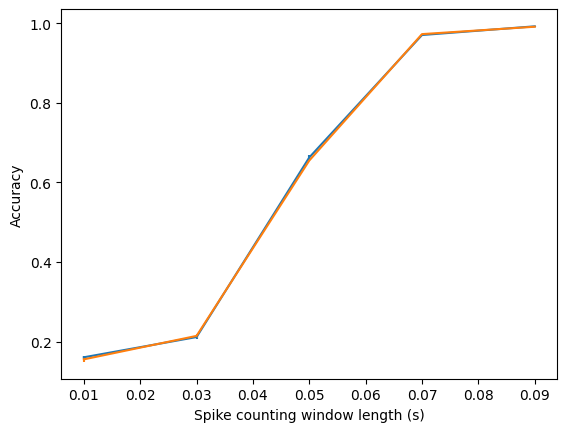

In [66]:
fig, ax = plt.subplots()
ax.errorbar(x=window_lengths, y=accuracies.mean(axis=(1)), yerr=accuracies.std(axis=(1)) / np.sqrt(num_splits), fmt='-')
ax.errorbar(x=window_lengths, y=shuffled_accuracies.mean(axis=(1)), yerr=shuffled_accuracies.std(axis=(1))/ np.sqrt(num_splits), fmt='-')
ax.set_xlabel('Spike counting window length (s)')
ax.set_ylabel('Accuracy')

In [67]:
### population sizes (fixed timescale)

window = .2

responses, labels = make_response_array(spike_times, stimulus_presentations, area_units, window)
shuffled_responses = trial_shuffle_responses(responses, conditions)

accuracies = np.zeros((len(pop_sizes), num_resamples, num_splits))
shuffled_accuracies = np.zeros_like(accuracies)

for i, pop_size in enumerate(pop_sizes):
    print('population size: {}'.format(pop_size))
    for j in range(num_resamples):
        pop_idx = np.random.choice(range(num_units), size=pop_size)
        responses_pop = responses[:, pop_idx]
        shuffled_responses_pop = shuffled_responses[:, pop_idx]
        
        k = 0
        for train_indices, test_indices in KFold(n_splits=num_splits, shuffle=True).split(responses_pop):
            clf = svm.SVC()
            clf.fit(responses_pop[train_indices], labels[train_indices])

            test_targets = labels[test_indices]
            test_predictions = clf.predict(responses_pop[test_indices])

            accuracies[i, j, k] = np.mean(test_targets == test_predictions)        

            clf.fit(shuffled_responses_pop[train_indices], labels[train_indices])

            test_targets = labels[test_indices]
            test_predictions = clf.predict(shuffled_responses_pop[test_indices])

            shuffled_accuracies[i, j, k] = np.mean(test_targets == test_predictions) 

            k += 1

population size: 1
population size: 6
population size: 11
population size: 16
population size: 21
population size: 26
population size: 31
population size: 36
population size: 41
population size: 46


Text(0, 0.5, 'Accuracy')

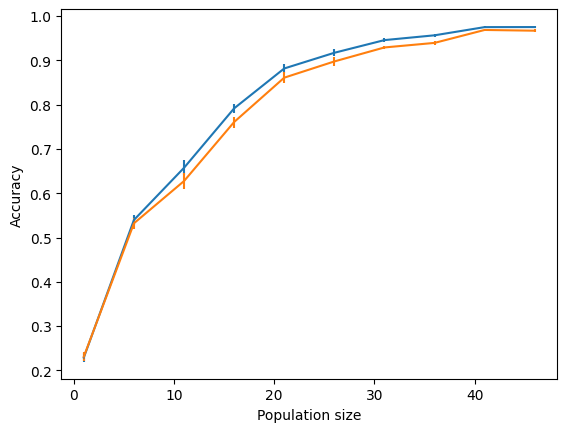

In [68]:
fig, ax = plt.subplots()
ax.errorbar(x=pop_sizes, y=accuracies.mean(axis=(1, 2)), yerr=accuracies.std(axis=(1, 2)) / np.sqrt(num_resamples*num_splits), fmt='-')
ax.errorbar(x=pop_sizes, y=shuffled_accuracies.mean(axis=(1, 2)), yerr=shuffled_accuracies.std(axis=(1, 2))/ np.sqrt(num_resamples*num_splits), fmt='-')
ax.set_xlabel('Population size')
ax.set_ylabel('Accuracy')

### Are the accuracy curves different for familiar vs novel images?


### Are the accuracy curves different in active vs passive blocks? Do noise correlations have differential impacts in those blocks?

### Is the structure of the population code different on hit vs miss trials? Can you predict hit vs miss by comparing the lick time to the decoding time course?

### Are other variables, including behavioral variables, also encoded in the population activity? Can you decode the running speed, pupil diameter, or licking behavior?

### What about in a different brain area? For example, is the image encoded in CA1 activity? What about in the joint activity across brain areas?